<a href="https://colab.research.google.com/github/ai-academy-ro/IBR_ML_Python/blob/main/5_4_ML_Programming_Implement_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting credit risk for a bank customer**


# **1. Dataset description**

<b>German credit data: </b></br>
<b>Age </b>(numeric)<br>
<b>Sex </b>(text: male, female)<br>
<b>Job </b>(numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)<br>
<b>Housing</b> (text: own, rent, or free)<br>
<b>Saving accounts</b> (text - little, moderate, quite rich, rich)<br>
<b>Checking account </b>(numeric, in DM - Deutsch Mark)<br>
<b>Credit amount</b> (numeric, in DM)<br>
<b>Duration</b> (numeric, in months)<br>
<b>Purpose</b>(text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)<br>
<b>Risk </b> (Value target - Good or Bad Risk)<br>

<a id="Libraries"></a> <br>
# **2. Libraries and data**

In [ ]:
import warnings
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1w6YFhjiFCruL_EHyN125nT4nPplqm1nm/view?usp=sharing'

id = link.split("/")[-2]
filename= 'german_credit_data.csv'

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile(filename)

In [ ]:
df_credit = pd.read_csv(filename, index_col=0)

<a id="Known"></a> <br>
# **3. First look at the data**

In [ ]:
#Searching for null values,data types and shape
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


In [ ]:
#Looking at unique values
df_credit.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64

In [ ]:
#Looking at a data sample
df_credit.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [ ]:
# Looking at the target variable to identify imbalance
df_credit['Risk'].value_counts()

good    700
bad     300
Name: Risk, dtype: int64

# **4. Feature Engineering** <a id="Feature Engineering"></a> <br>

## Null treatement

In [ ]:
# Null treatement
df_credit['Saving accounts'] = df_credit['Saving accounts'].fillna('no_inf')
df_credit['Checking account'] = df_credit['Checking account'].fillna('no_inf')

## Treatement of Categorical variables

In [ ]:
categ = list(df_credit.select_dtypes(['object']).columns) + list(df_credit.select_dtypes(['category']).columns)
print(categ)

['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']


In [ ]:
# One hot encoder for Categorical Variables
print('Data frame shape before Categorical Values encoding: ',df_credit.shape)
df_credit = pd.get_dummies(data=df_credit, columns=categ)
print('Data frame shape after Categorical Values encoding: ',df_credit.shape)
del df_credit['Risk_good']

Data frame shape before Categorical Values encoding:  (1000, 10)
Data frame shape after Categorical Values encoding:  (1000, 28)


In [ ]:
df_credit.head()

,Age,Job,Credit amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Saving accounts_little,Saving accounts_moderate,Saving accounts_no_inf,Saving accounts_quite rich,Saving accounts_rich,Checking account_little,Checking account_moderate,Checking account_no_inf,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Risk_bad
0,67,2,1169,6,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
1,22,2,5951,48,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
2,49,1,2096,12,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
3,45,2,7882,42,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,53,2,4870,24,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1


## Looking at the correlation of the data

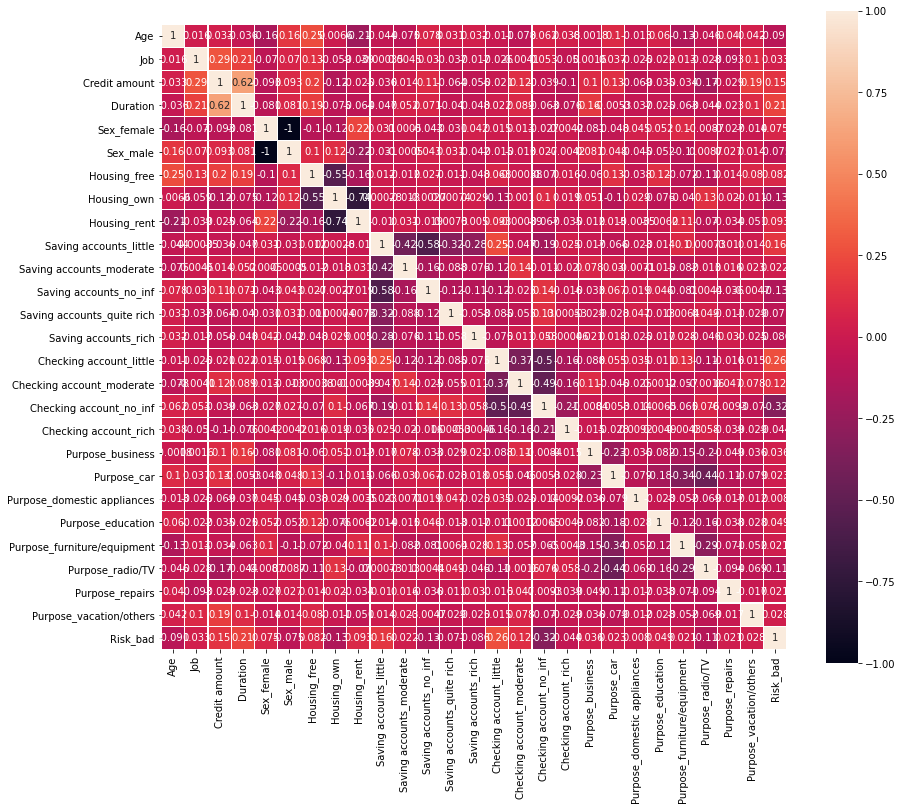

In [ ]:
plt.figure(figsize=(14,12))
sns.heatmap(df_credit.astype(float).corr(),linewidths=0.1,vmax=1.0,
            square=True,  linecolor='white', annot=True)
plt.show()

In [ ]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [ ]:
corr_features = correlation(df_credit, 0.9)
print(corr_features)

for column in corr_features:
  df_credit.drop(column, axis=1,inplace=True)

{'Sex_male'}


# **5. Train/Test split and Scaling** <a id="Train/Test split and Scaling"></a> <br>


## Import libraries

In [ ]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, fbeta_score
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

## Prepare and split Dataset into Train and Test

In [ ]:
target = 'Risk_bad'
predictor = df_credit.drop([target], axis=1).columns

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(df_credit[predictor], df_credit[target], test_size = 0.2, random_state=42)

## Scale input for distance-based models (Logistic Regression, KMeans, Support Vector Classifier)

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler()

X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)

# **6. Implement models** <a id="Implement models"></a> <br>

### Define model evaluation functions

In [ ]:
# Evaluate results based on the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plot_cm(y_test, y_pred):
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred, values_format='d', cmap='Blues')
  plt.show()

In [ ]:
# Evaluate model performance
def clasif_report(y_test,y_pred):
  print(classification_report(y_test, y_pred))

In [ ]:
# Determine model robustness
def roc_auc(model, X_train, y_train, y_test, y_pred, n_splits):
  roc_auc_test = metrics.roc_auc_score(y_test, y_pred, average='micro')
  roc_auc_cv = cross_val_score(estimator = model, X = X_train, y = y_train, scoring = 'roc_auc', cv = n_splits)
  roc_auc_cv_mean = roc_auc_cv.mean()
  roc_auc_cv_std = roc_auc_cv.std()

  print('Test ROC AUC           : {:.4f}'.format(roc_auc_test))
  print('Cross-val ROC AUC mean : {:.4f}'.format(roc_auc_cv_mean))
  print('Cross-val ROC AUC std  : {:.4f}'.format(roc_auc_cv_std))

In [ ]:
#Plotting the ROC curve
def plot_roc_curve(model, X_test, y_test):
  y_pred_prob = model.predict_proba(X_test)[:,1]              # Predict probabilities
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)       # Generate ROC curve values: fpr, tpr, thresholds

  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr, tpr)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.show()

### Logistic Regression

In [ ]:
# import libraries
from sklearn.linear_model import LogisticRegression

### K-Nearest Neighbors Classifier

In [ ]:
# import libraries
from sklearn.neighbors import KNeighborsClassifier

### Decision Tree Classifier

In [ ]:
# import libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

### Ensemble methods: Random Forrest Classifier

In [ ]:
# import libraries
from sklearn.ensemble import RandomForestClassifier

### Ensemble methods: XGBoost Classifier

In [ ]:
# import libraries
from xgboost import XGBClassifier